Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.00e-03
Saving data at t = 6.01e-03
Saving data at t = 7.01e-03
Saving data at t = 8.01e-03
Saving data at t = 9.01e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

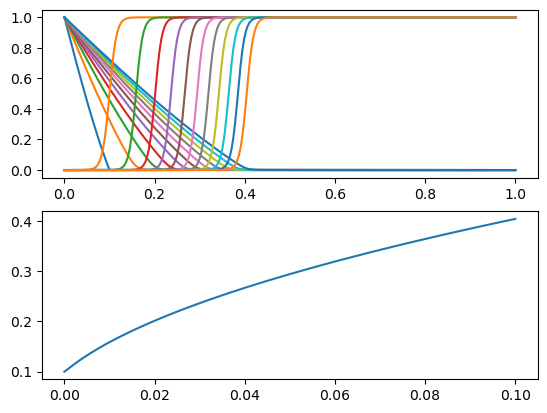

In [1]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar

# Parameters
# ==========
# Number of grid points
Nx = 256 + 1
# Size of domain in x
Lx = 1.0
# x-coordinate vector
x = np.linspace(0, Lx, Nx)
# Grid spacing in x
dx = x[1] - x[0]

# Phase-field parameters
A = 1.0
eps = (1/128)
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi and T
phi = 0.5*(1 + np.tanh((x - h)/(2*eps)))
T = np.zeros(x.size)
T[x<h] = 1.0 - erf(lam*x[x<h]/h)/erf(lam)
dphi = np.zeros(x.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nx, 101))
T_save = np.zeros((Nx, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

# Time-stepping parameters
simtime = 0.0   # Current simulation time

dt = 0.8*dx**2  # Time step


t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D)
Lphi = np.eye(Nx) - 0.5*dt*D2phi
D2T = D2(1.0)
LT = np.eye(Nx) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs = np.zeros(Nx)
dphi = np.zeros(x.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

def step_time():
    global phi, T
    rhs[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T)
    )
    rhs[0] = 0.0
    dphi[:] = iLphi@rhs # iLphi @ rhs OR  np.matmul(iLphi,rhs)
    phi += dphi
    rhs[:] = T + 0.5*dt*D2T@T + dphi
    rhs[0] = 1.0
    T[:] = iLT@rhs
    return

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x, T_save[:,::10])
ax.plot(x, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()

In [3]:
print(dt/eps**2)
print(dt/dx**2)
print(dx)
print(lam)

0.2
0.8
0.00390625
0.6200626333135905


In [5]:
#################

In [23]:
#np.savez('N861_dtchange_eps128', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)

In [ ]:
######################